In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from joblib import Parallel, delayed

__AUTHOR__ = 'Kirgsn'

class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe to in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        """
        if conv_table is None:
            self.conversion_table = \
                {'int': [np.int8, np.int16, np.int32, np.int64],
                 'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                 'float': [np.float16, np.float32, ]}
        else:
            self.conversion_table = conv_table

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=-1)(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)

        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):

        # skip NaNs
        if s.isnull().any():
            if verbose:
                print(colname, 'has NaNs - Skip..')
            return s

        # detect kind of type
        coltype = s.dtype
        if np.issubdtype(coltype, np.integer):
            conv_key = 'int' if s.min() < 0 else 'uint'
        elif np.issubdtype(coltype, np.floating):
            conv_key = 'float'
        else:
            if verbose:
                print(colname, 'is', coltype, '- Skip..')
            print(colname, 'is', coltype, '- Skip..')
            return s

        # find right candidate
        for cand, cand_info in self._type_candidates(conv_key):
            if s.max() <= cand_info.max and s.min() >= cand_info.min:

                if verbose:
                    print('convert', colname, 'to', str(cand))
                return s.astype(cand)

        # reaching this code is bad. Probably there are inf, or other high numbs
        print(("WARNING: {} " 
               "doesn't fit the grid with \nmax: {} "
               "and \nmin: {}").format(colname, s.max(), s.min()))
        print('Dropping it..')
        

df = pd.read_csv("train.csv")

reducer = Reducer()
df = reducer.reduce(df)

def display_all_rows(data, num=None):
    pd.set_option('display.max_rows', num)
    display(data)
    pd.set_option('display.max_rows', 100)

def display_visitor(data, No):
    criteria = data['VisitNumber'] == No
    display(data[criteria])
    
def display_all_columns(data):
    pd.set_option('display.max_columns', None)
    display(data)
    pd.set_option('display.max_columns', 100)
    

## 1차 가공
# Fill Na
# Dept Na -> Upc: 0.1, Dept: Na. FN: 0.1
c = df['DepartmentDescription'].isnull()
df[c] = df[c].fillna({'Upc': 0.1, 'DepartmentDescription': 'Na', 'FinelineNumber': 0.1})

# 아래 코드
df_d_sum = df.groupby(['VisitNumber', 'DepartmentDescription'], as_index=False)['ScanCount'].agg('sum').sort_values(['VisitNumber', 'ScanCount', 'DepartmentDescription'], ascending=[1, 0, 1])
df_d_sum['abs_sum'] = df_d_sum.assign(abs=df_d_sum['ScanCount'].abs()).groupby(['VisitNumber'])['abs'].transform('sum')

# change 'abs_sum' for div
criteria = df_d_sum['abs_sum'] == 0
df_d_sum.loc[criteria, 'abs_sum'] = 999

# create ratio
df_d_sum['ratio'] = df_d_sum['ScanCount'] / df_d_sum['abs_sum']

# abs_sum 원복
criteria = df_d_sum['abs_sum'] == 999
df_d_sum.loc[criteria, 'abs_sum'] = 0

# Dept Na 였던 VisitNumber append
diff = set(df.VisitNumber) - set(df_d_sum.VisitNumber)
df_d_sum = df_d_sum.append(pd.DataFrame({'VisitNumber': list(diff)},)).fillna({'DepartmentDescription': 'Na',
                                                                         'ScanCount': 0,
                                                                         'ratio':0 })
# create pivot table
df_pivot = df_d_sum.pivot(index='VisitNumber', columns='DepartmentDescription', values='ratio').fillna(0)
df_pivot = pd.merge(df_pivot, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')

# create TT vs ratio
df_ratio = pd.merge(df_d_sum, df[['VisitNumber', 'TripType']].drop_duplicates(), on='VisitNumber')
df_ratio = df_ratio.sort_values(['TripType', 'VisitNumber', 'ratio'], ascending=[1, 1, 0]).iloc[:, [2, 5, 0, 4]].set_index(['VisitNumber', 'TripType'])

df_check_ratio = df_ratio.set_index('DepartmentDescription', append=True).sum(level=[1,2]).rename(columns={'ratio':'ratio_sum'})
df_check_ratio = df_check_ratio.sort_values(['TripType', 'ratio_sum'], ascending=[1, 0])

# Dept ratio within TripType
df_check_ratio['TT_Dept_ratio'] = df_check_ratio/df_check_ratio.sum(level=0)


## 2차 가공
# top5 Dept
top5_Dept = list(df_check_ratio.groupby('TripType').head(5).reset_index()['DepartmentDescription'].drop_duplicates())

# diff(VisitNumber of ~isin Dept )
c = df_ratio['DepartmentDescription'].isin(top5_Dept)
diff = set(df['VisitNumber'].unique()) - set(df_ratio[c].reset_index()['VisitNumber'].unique())
df_ratio_top5 = df_ratio[c]

# dept top5
df_train = df_ratio_top5.reset_index().pivot(index='VisitNumber',\
                                  columns='DepartmentDescription',\
                                 values='ratio').append(pd.DataFrame(index=diff))

# New_col isZero&Negative
temp1 = df_d_sum.iloc[:, [2,1]].set_index('VisitNumber').sum(level=0)
temp1['isZeroNegative'] = False
c = temp1['ScanCount'] <= 0
temp1.loc[c, 'isZeroNegative'] = True
temp1 = temp1.iloc[:, [1]]

# New_col boolean dept:
c2 = df_d_sum.reset_index()['VisitNumber'].isin(diff)

boolean_dept = list(df_ratio.reset_index().loc[c2, 'DepartmentDescription'].unique())

c = df_d_sum.reset_index()['DepartmentDescription'].isin(boolean_dept)
df_sub = df_d_sum.reset_index()[c&c2].iloc[:, [3, 1]]
df_sub.loc[:, 'val'] = True
df_sub.loc[:, 'DepartmentDescription'] = df_sub['DepartmentDescription'].apply(lambda x: str(x) + '_boolean') 
df_sub = df_sub.pivot('VisitNumber', 'DepartmentDescription', 'val').fillna(False)

# Dept top5 + boolean
temp = pd.DataFrame(data=False, columns=df_sub.columns, index=df_train.index).\
 rename({'DepartmentDescription':'VisitNumber'}, axis='index')
df_train = pd.concat([df_train, temp], axis=1)

# + New_col
df_train = pd.concat([df_train, temp1], axis=1)

# + TripType
temp = df.loc[:, ['VisitNumber','TripType']].drop_duplicates('VisitNumber').set_index('VisitNumber')
df_train = pd.concat([df_train, temp], axis=1)



In [172]:
df_ratio_check_sub = df_ratio.set_index('DepartmentDescription', append=True).sum(level=[1,2])
temp = df_ratio_check_sub.assign(abs_sum=df_check_ratio['ratio_sum'].abs()).sum(level=0)['abs_sum']
df_ratio_check_sub['ratio2'] = df_ratio_check_sub.join(temp).apply(lambda x: x['ratio']/x['abs_sum'], axis=1)
df_ratio_check_sub = df_ratio_check_sub.assign(abs_ratio=df_ratio_check_sub['ratio2'].abs()).sort_values(['TripType', 'abs_ratio'], ascending=[1, 0]).drop('abs_ratio', axis=1)

c = df_ratio_check_sub.reset_index()['ratio2'] > 0.2
df_ratio_check_sub.reset_index()[c]

# # heatmap
# plt.figure(figsize=(5, 5))
# cmap = mcolors.LinearSegmentedColormap.from_list("n",['#000066','#000099','#0000cc','#1a1aff','#6666ff','#b3b3ff',
#                        '#ffff00','#ffcccc','#ff9999','#ff6666','#ff3333','#ff0000'])
# norm = plt.Normalize(-100,100)

# sns.heatmap(df_ratio_check_sub.reset_index().groupby('TripType').head(3).pivot('DepartmentDescription', 'TripType', 'ratio2'), cmap=cmap, norm=norm)
# plt.show()

,TripType,DepartmentDescription,ratio,ratio2
0,3,FINANCIAL SERVICES,3002.986508,0.824317
58,4,PHARMACY OTC,269.657522,0.779357
95,5,PHARMACY OTC,1875.959674,0.408439
96,5,PHARMACY RX,1422.962100,0.309811
157,6,"CANDY, TOBACCO, COOKIES",437.314694,0.342455
158,6,"LIQUOR,WINE,BEER",430.147428,0.336842
211,7,SERVICE DELI,1546.277132,0.268838
273,8,DSD GROCERY,2763.609524,0.227280
448,14,FABRICS AND CRAFTS,2.100289,0.525072
457,15,CELEBRATION,311.739607,0.318752


# searching discriminant features b/w TripTypes
    

In [246]:
def plot_tt(tt=999, data=df):
    c = df['TripType'] == tt
    df_tt = df[c].loc[:, ['TripType', 'Upc', 'ScanCount', 'DepartmentDescription', 'FinelineNumber']].reset_index(drop=True)
    data = df_tt.set_index('DepartmentDescription').sum(level=0)['ScanCount'].reset_index().sort_values('ScanCount', ascending=False)

    f, axes = plt.subplots(1,2, figsize=(10, 5))
    plot = sns.barplot(x='DepartmentDescription', y='ScanCount', data=data[:10], ax=axes[0])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.set_title('Dept vs {}'.format(tt))

    data = df_tt.set_index('FinelineNumber').sum(level=0)['ScanCount'].reset_index().sort_values('ScanCount', ascending=False)
    plot = sns.barplot(x='FinelineNumber', y='ScanCount', data=data[:10], ax=axes[1])
    plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    plot.set_title('FN vs {}'.format(tt))   

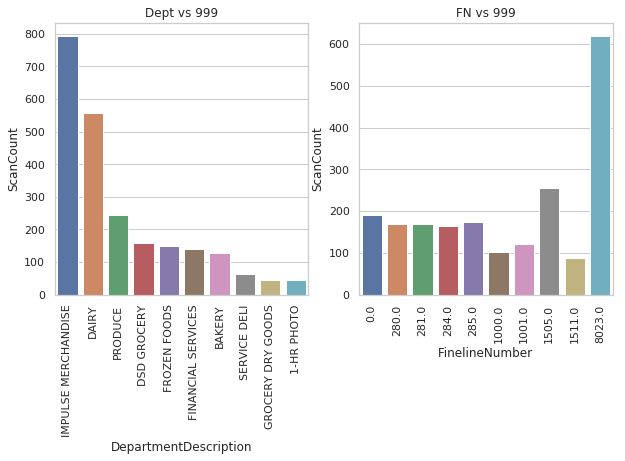

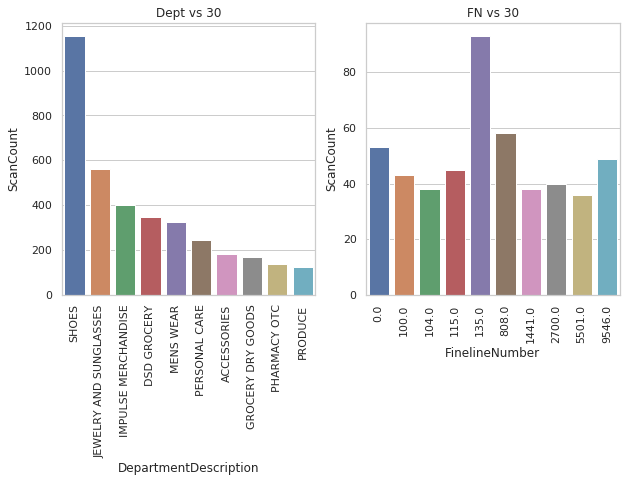

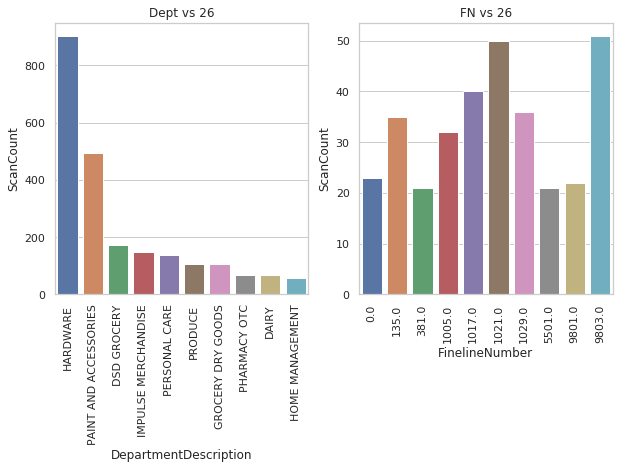

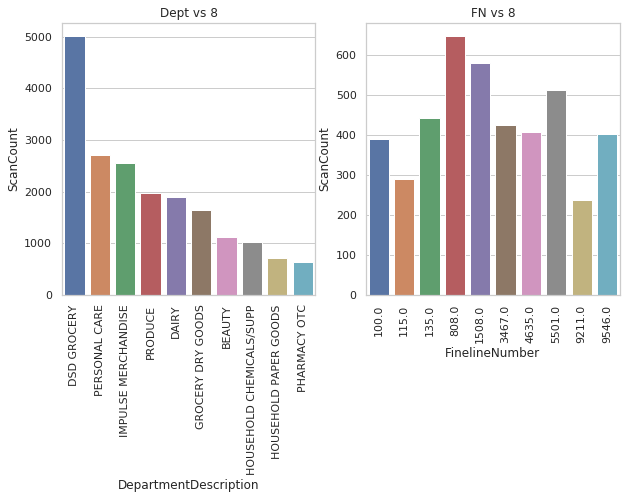

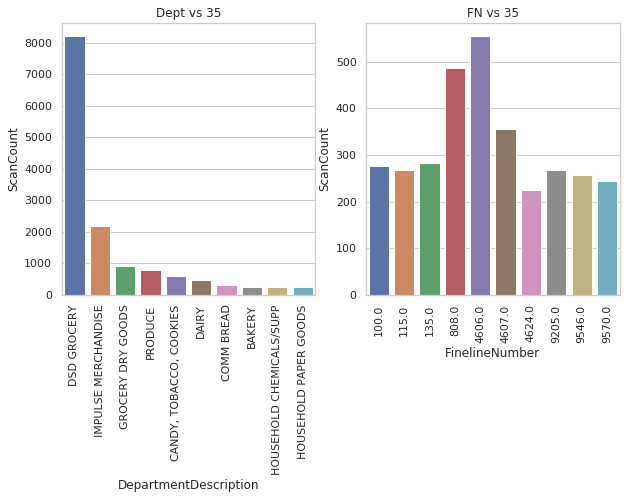

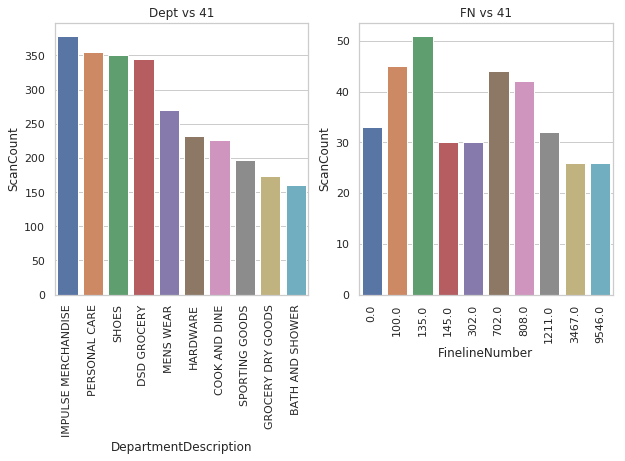

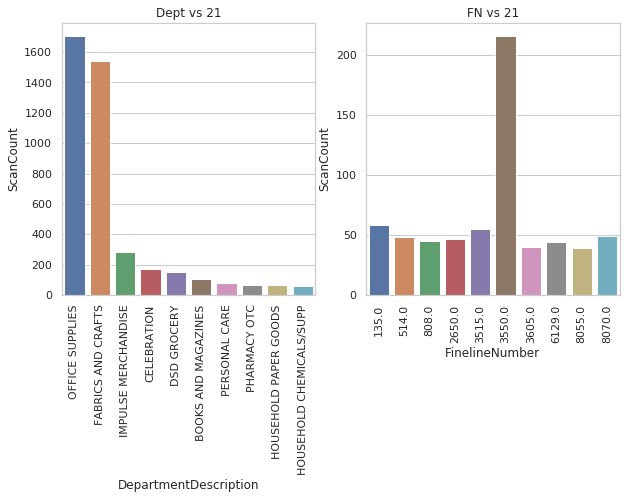

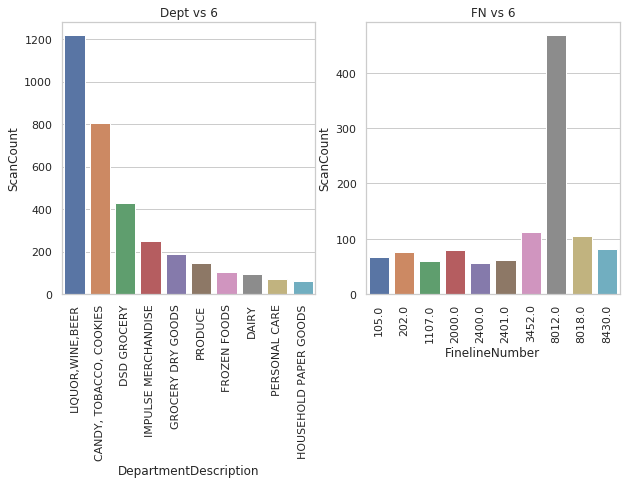

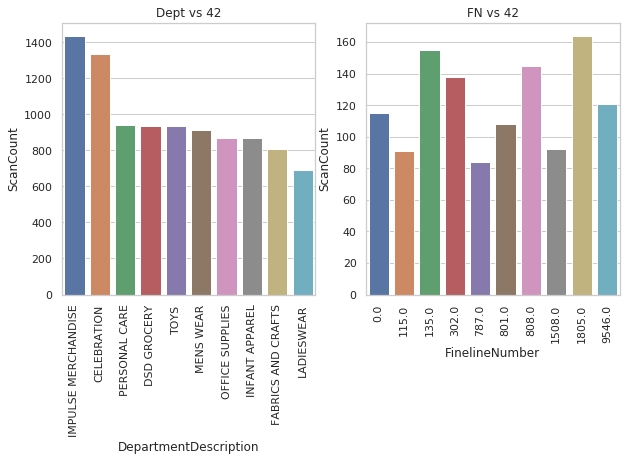

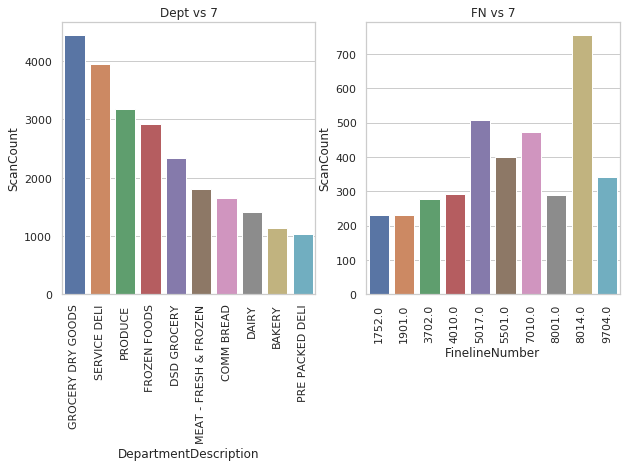

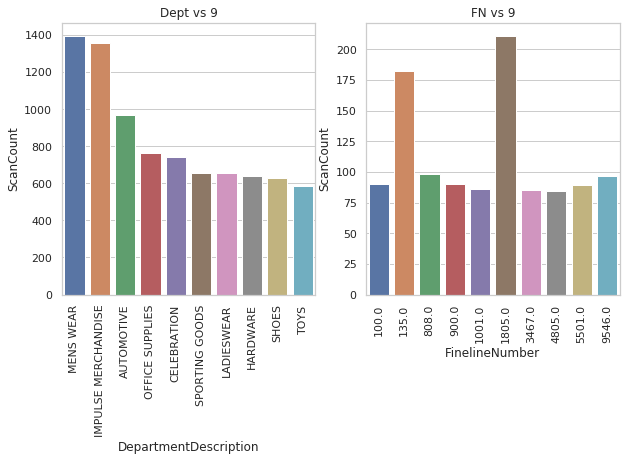

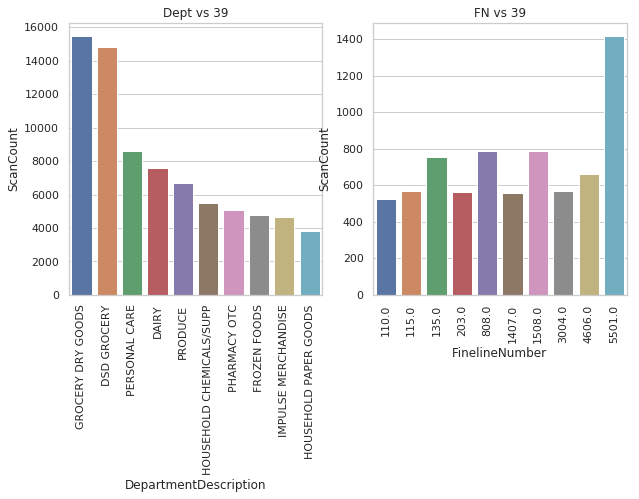

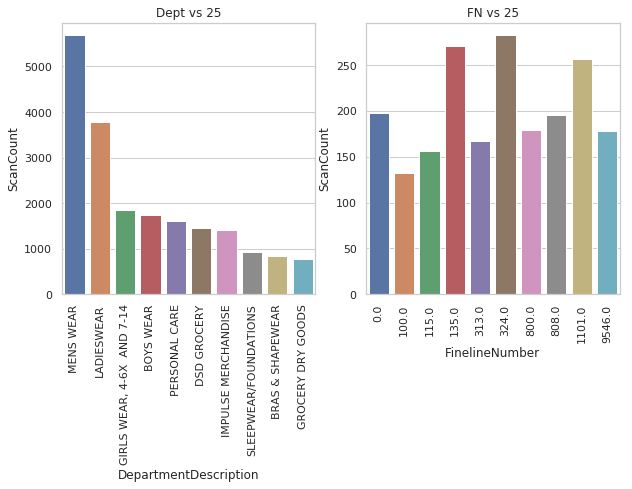

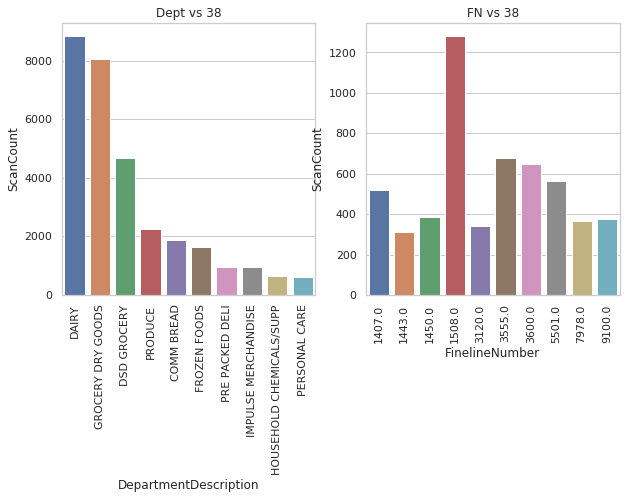

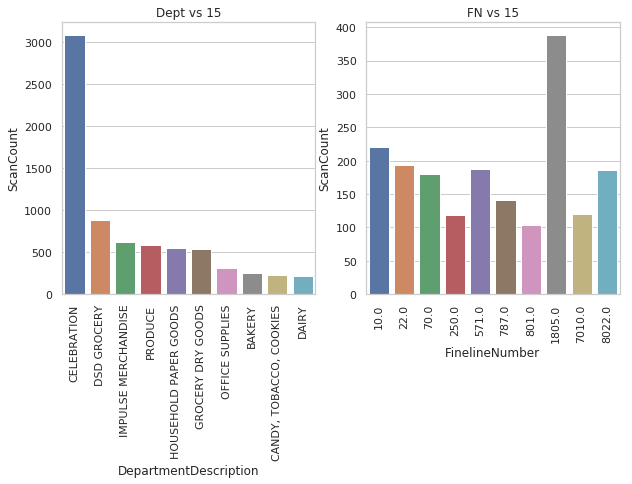

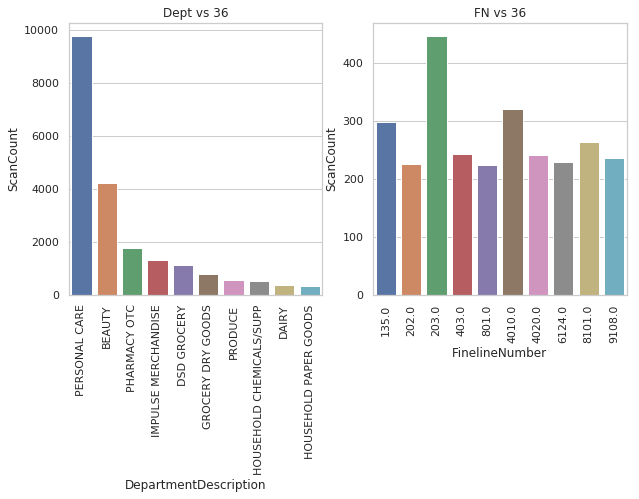

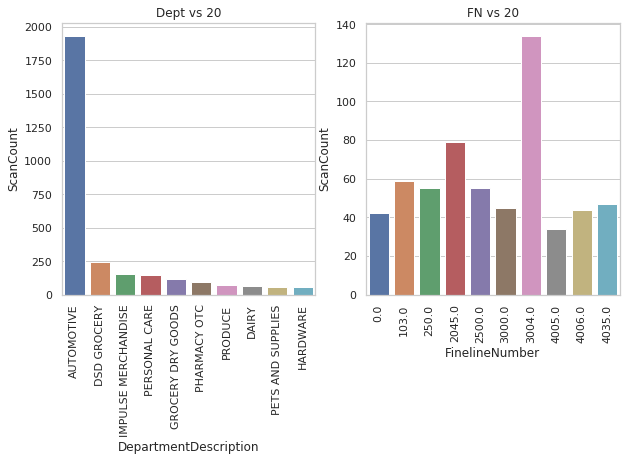

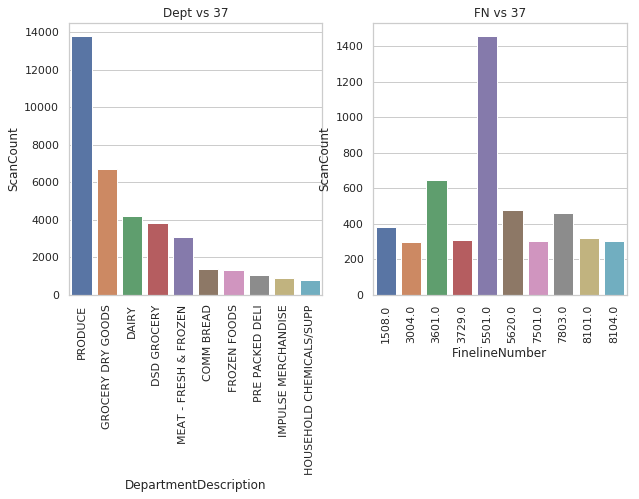

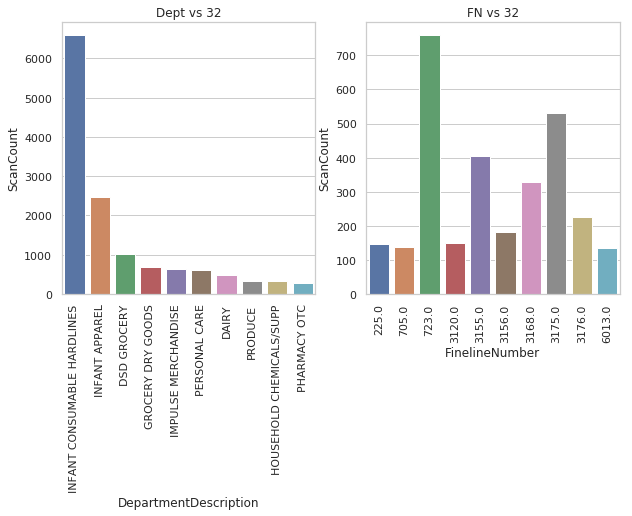

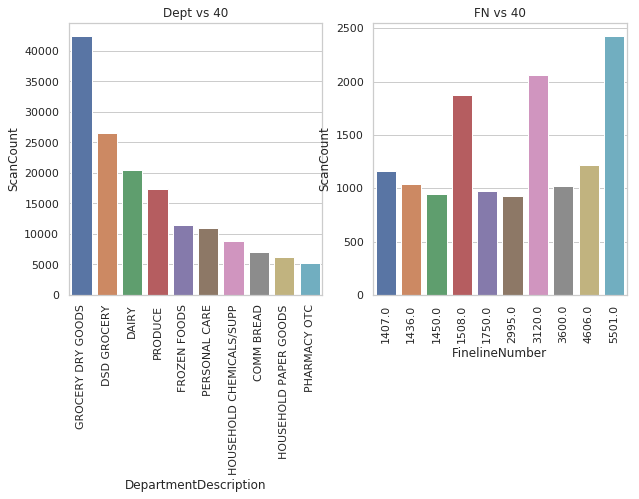

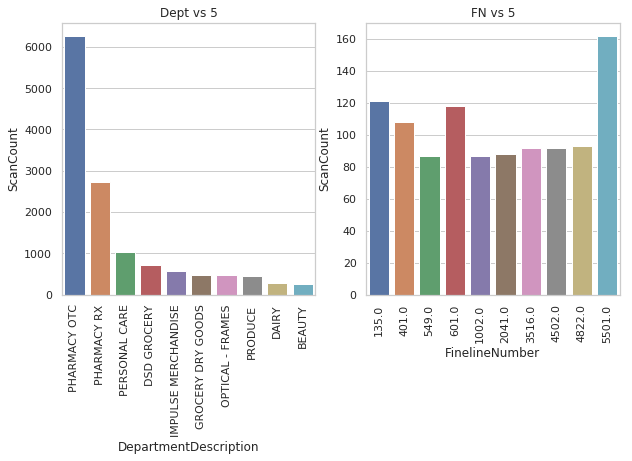

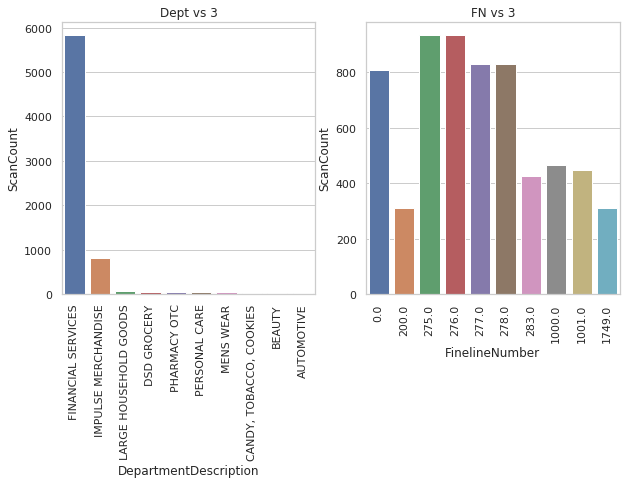

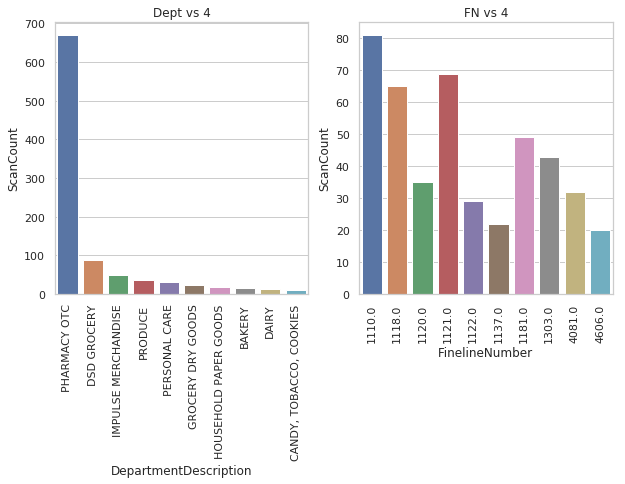

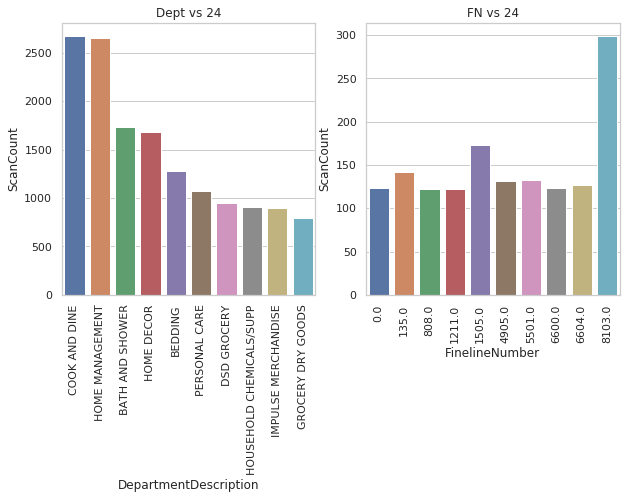

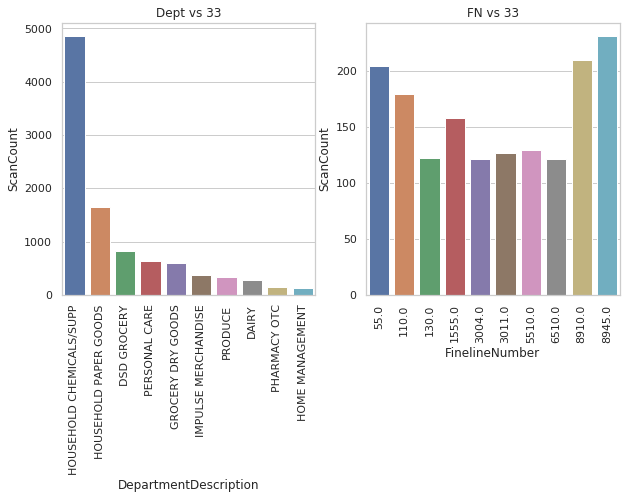

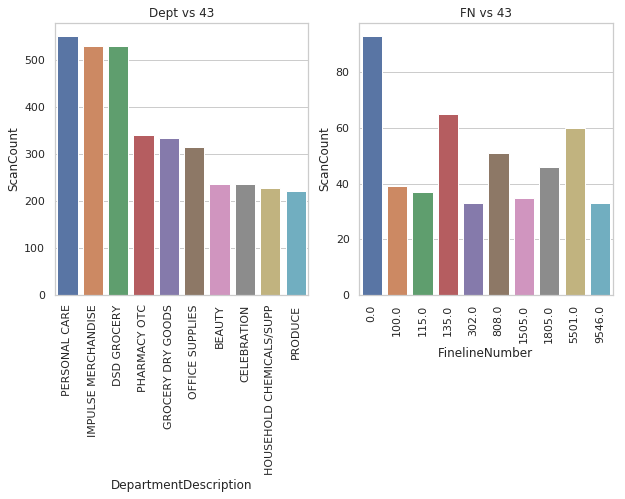

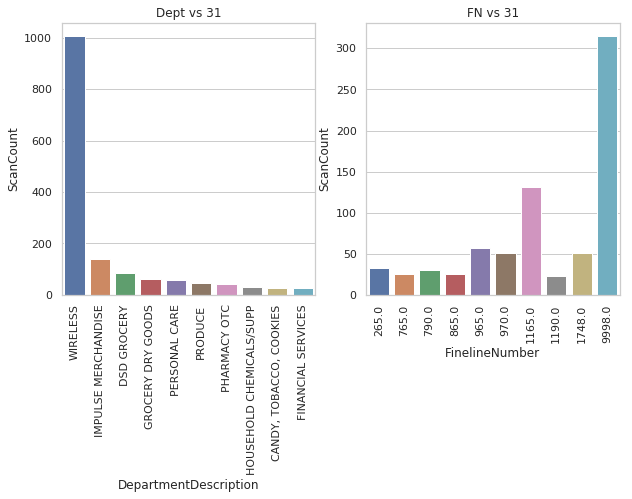

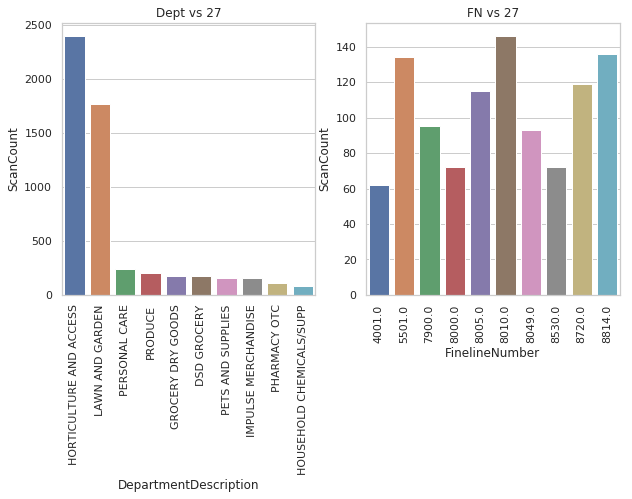

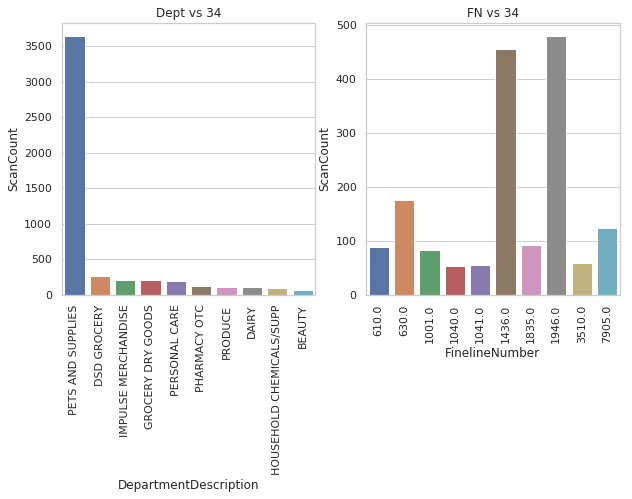

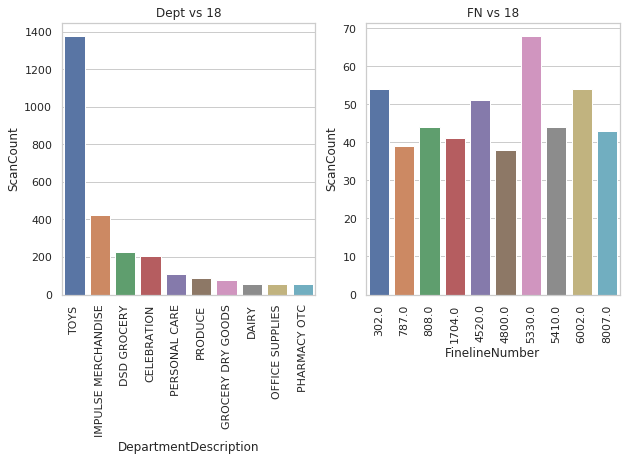

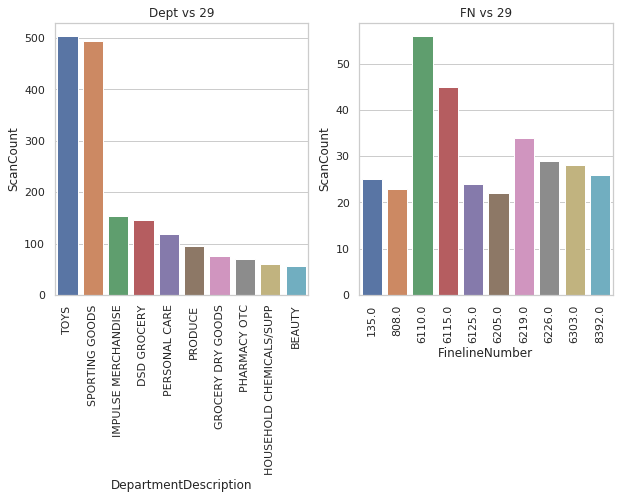

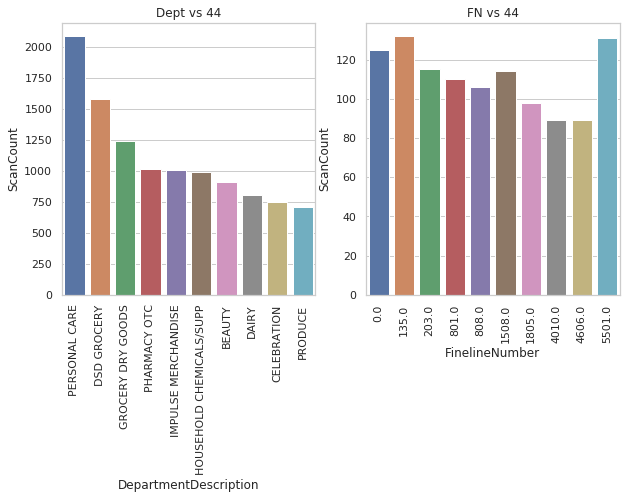

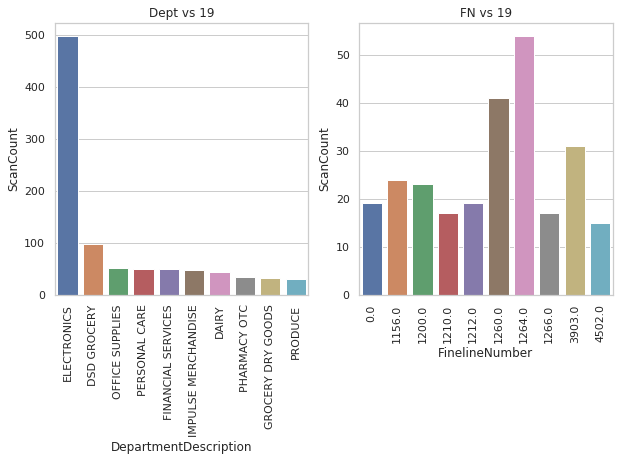

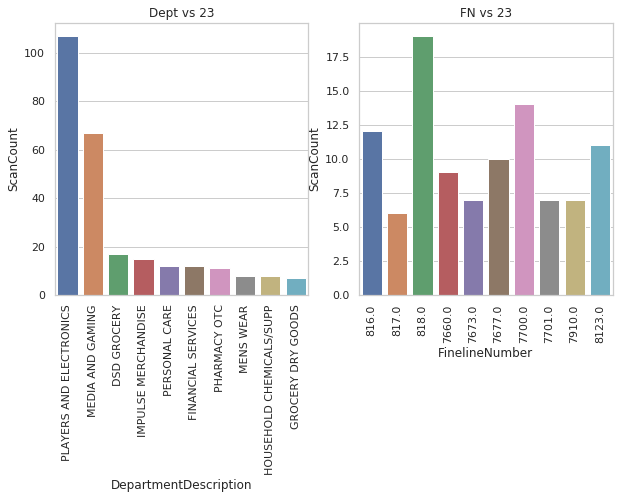

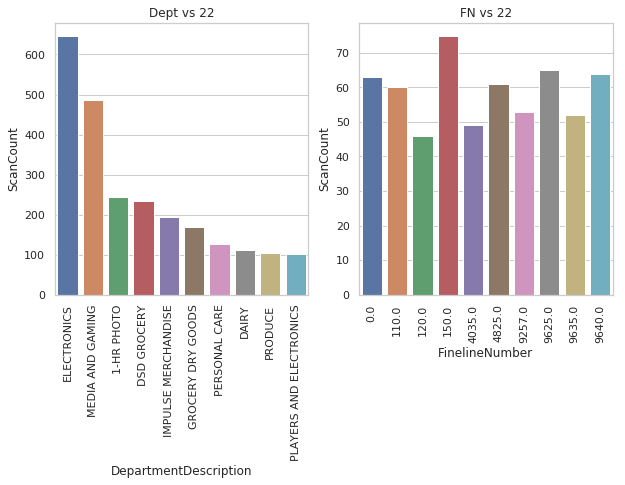

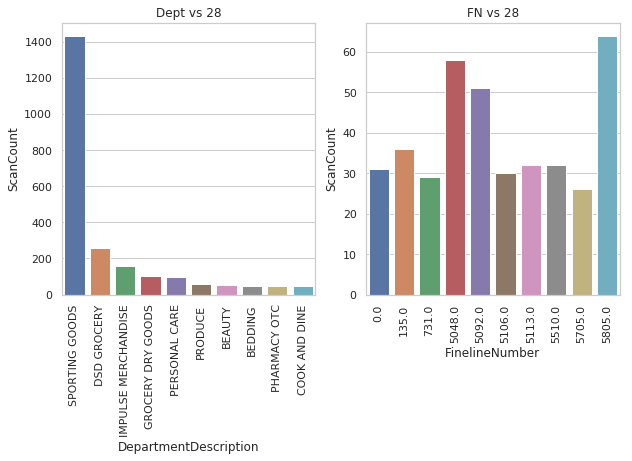

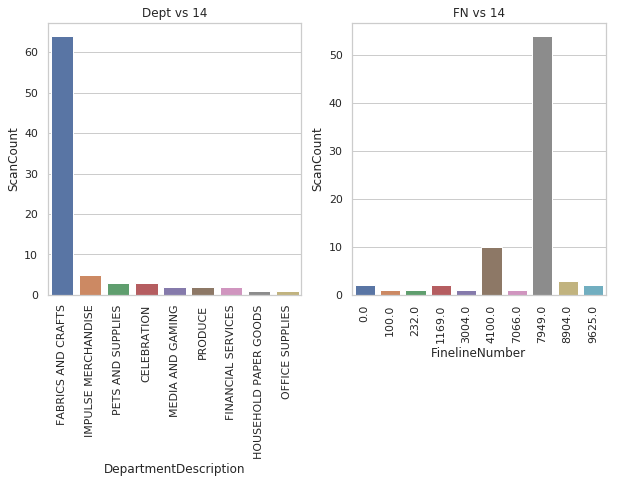

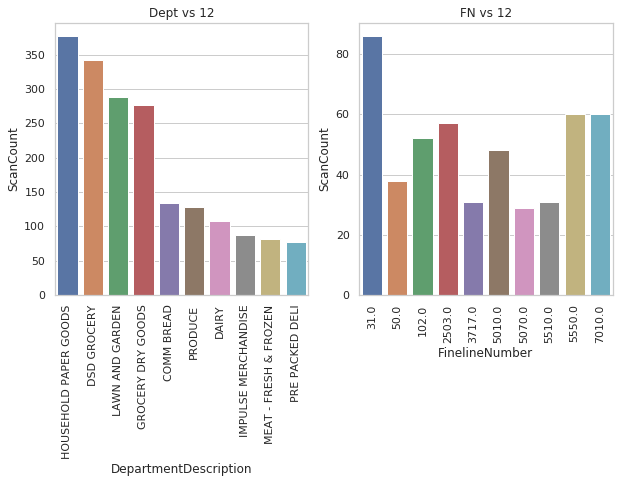

In [250]:
for tt in df['TripType'].unique():
    plot_tt(tt=tt)
    plt.show()